## Image Generation from parent and childern Images 
(change to students in a Lecture Room; Output is GroupPhoto, GroupLabel)

**Inputs**: Parent (Background Image), Childern (Image to merge over the Parent)

**Output**: Grouped and Augmented imgage, Annotation of Group image

**Params**: 
    * Parent : The background images/ images (In future parents, e.g. different exposures i.e. differnt set of children)
    * Childern : The different children with which can be stacked in the Parent image

**Operataions**:
    * Cropping: Crop
    * Augementation : Augment the child images (rotate, zoom, horizontal flip, etc.)
    * Grouping : Group (4) the childern randomly and stack them in the parent image.
    * Annotating: Annotate the position of the children on the parent image.

#### WARNING!!: Use PNG in future to get better child images


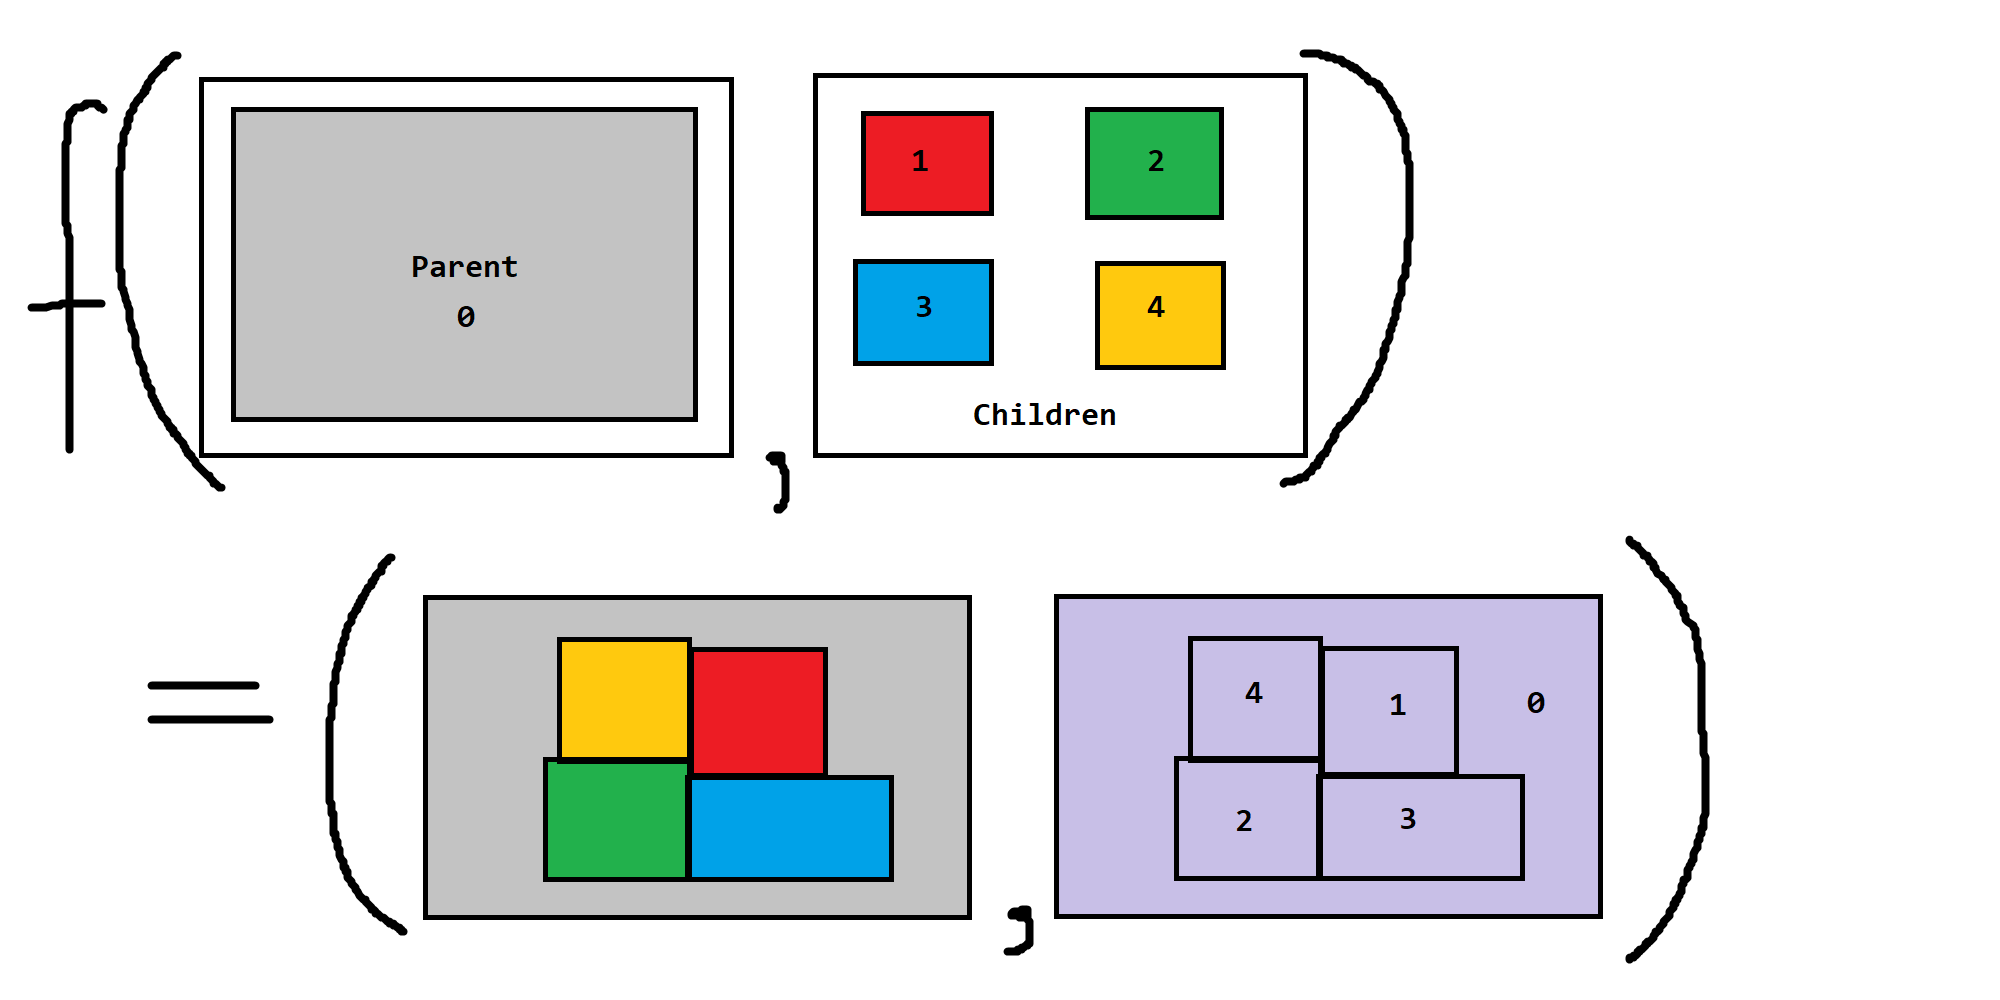

In [40]:
import numpy as np
import cv2
import imgaug
import glob
import random
import matplotlib.pyplot as plt
import pathlib
import json

In [41]:
from random import seed
from random import randint
from random import random
seed(1)

In [42]:
from imgaug import augmenters as iaa
from PIL import Image

In [43]:
from numpy import load

In [44]:
BOXES_PATH = pathlib.Path("/home/joseph/work/img_gen_aug/data/boxes")
ROOMS_PATH = pathlib.Path("/home/joseph/work/img_gen_aug/data/rooms")

In [45]:
BOXES_EXP1  = np.load(BOXES_PATH / "exp1_dataset/exp1_images.npy", allow_pickle=True )
LABELS_EXP1 = np.load(BOXES_PATH / "exp1_dataset/exp1_labels.npy", allow_pickle=True )

# Needs to make room images as npy arrays
ROOMS_EXP1  = Image.open(ROOMS_PATH / "exp_1/Img_023_a.bmp")
ROOMS_EXP1 = np.array(ROOMS_EXP1)

# Importing config for boxes

with open(BOXES_PATH / "exp1_dataset/exp1_config.json") as config:
    CONFIG_EXP1 = json.load(config)

In [46]:
ROOMS_EXP1 = np.reshape(ROOMS_EXP1, [1, ROOMS_EXP1.shape[0], ROOMS_EXP1.shape[1], ROOMS_EXP1.shape[2]])

In [47]:
ROOMS_EXP1.shape

(1, 963, 964, 3)

In [48]:
CONFIG_EXP1

{'background': 0,
 'class_2_green': 1,
 'class_3_blue': 2,
 'class_4_grey': 3,
 'class_5_white': 4,
 'class_6_red': 5,
 'class_7_darkblue': 6}

In [49]:
BOXES_EXP1.shape

(56, 128, 128, 3)

In [50]:
LABELS_EXP1.shape

(56,)

### Function to convet to PNG format

In [51]:
# Image batch has size (BATCH_NUM, width, height, 3)
# If image batch in PNG, dont use, will remove alpha channel data
def img_batch_to_png(img_batch):
    img_batch_png = np.ones([img_batch.shape[0], img_batch.shape[1], img_batch.shape[2],4]) *255
    img_batch_png[:,:,:,:3] = img_batch
    
    return img_batch_png

In [52]:
BOXES_EXP1 = img_batch_to_png(BOXES_EXP1)

In [53]:
ROOMS_EXP1 = img_batch_to_png(ROOMS_EXP1)

### Sample

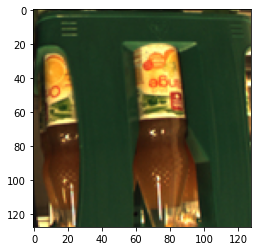

In [54]:
plt.imshow(BOXES_EXP1[0,:,:,:]/255)

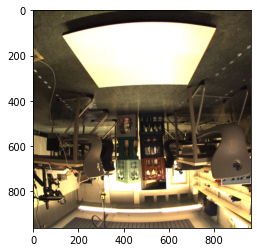

In [55]:
plt.imshow(ROOMS_EXP1[0,:,:,:]/255)

### Loading Images

In [56]:
# CWD = pathlib.Path.cwd()
# STUD_PATH = CWD / 'src/students'
# ROOM_PATH = CWD / 'src/rooms'

In [57]:
# STUDS = list(STUD_PATH.glob('**/*.png'))
# ROOMS = list(ROOM_PATH.glob('**/*.png'))
# print('No. of Students:' + str(len(STUDS)))
# print('No. of Rooms:'+ str(len(ROOMS)))

In [58]:
STUDS = BOXES_EXP1
ROOMS = ROOMS_EXP1
print('No. of Students:' + str(len(STUDS)))
print('No. of Rooms:'+ str(len(ROOMS)))

No. of Students:56
No. of Rooms:1


In [59]:
STUD_SIZE = (70,70)
ROOM_SIZE = (256,256)

In [60]:
STUD_ARR = np.zeros([len(STUDS),STUD_SIZE[0],STUD_SIZE[1],4])
ROOM_ARR = np.zeros([len(ROOMS),ROOM_SIZE[0],ROOM_SIZE[1],4])

In [61]:
# Creating array of student images
for i in range(len(STUDS)):
    img = STUDS[i,:,:,:]
    img = cv2.resize(img, STUD_SIZE)
    img = np.array(img, dtype=np.float32)
    STUD_ARR[i,:,:,:] = img

In [62]:
STUD_ARR.shape

(56, 70, 70, 4)

In [63]:
# Creating array of room images
for i in range(len(ROOMS)):
    img = ROOMS[i,:,:,:]
    img = cv2.resize(img, ROOM_SIZE)
    img = np.array(img, dtype=np.float32)
    ROOM_ARR[i,:,:,:] = img

In [64]:
print('STUD', STUD_ARR.shape)
print('ROOM', ROOM_ARR.shape)

STUD (56, 70, 70, 4)
ROOM (1, 256, 256, 4)


### Overlaying Students in Room

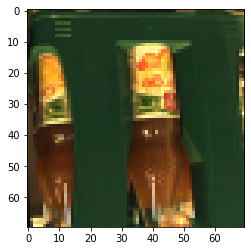

In [65]:
stud_sample = STUD_ARR[0]
room_sample = ROOM_ARR[0]
plt.imshow(stud_sample/255)

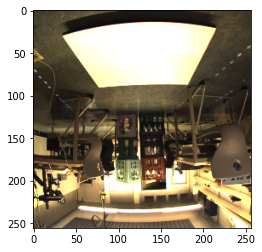

In [66]:
group_img = np.array(room_sample)
plt.imshow(group_img/255)

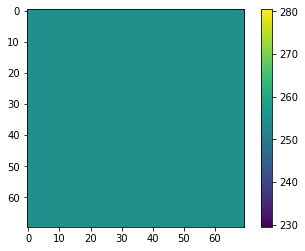

In [67]:
plt.imshow(stud_sample[:,:,3])
plt.colorbar()

### Placing boxes randomly

In [68]:
def place_box(room_img, stud_img, x_lim, y_lim, width, height):
    x1 = x_lim       
    x2 = x1 + width    
    y1 = y_lim        
    y2 = y1 + height

    stud_resized = cv2.resize(stud_img ,(x2-x1,y2-y1))
    for i in range(0,y2-y1):
        for j in range(0,x2-x1):
            if (stud_resized[i,j,3]>=100):
                room_img[y1+i, x1+j, :] = stud_resized[i,j,:]
                
    # Creating annotation of that BOX
    annotation = np.zeros((room_img.shape[0], room_img.shape[1]))
    stud_annot = stud_resized[:,:,3]
    annotation[y1:y2, x1:x2] = stud_annot
    
    return group_img, annotation, x2, y2

In [69]:
def random_pos_gen(pellet_x = 35, pellet_y = 30, x_var = 5, y_var = 6, w_init=90, h_init=90, w_var=10, h_var=10):
    # rename to random_val_gen
    # Generate random positions
    x_init = pellet_x + int(np.random.randn(1)* x_var) # within the pellet limits
    y_init = pellet_y + int(np.random.randn(1)* y_var) # on the pellet
    
    #Generate random sizing
    w_rand = w_init + int(np.random.randn(1)* x_var) # within the pellet limits
    h_rand = h_init + int(np.random.randn(1)* y_var) # on the pellet  
    
    return [x_init, y_init, w_rand, h_rand]

In [70]:
# Should also return box label 
def random_box(img_arr):    
    random_index = randint(0, len(img_arr) - 1)

    return [img_arr[random_index], LABELS_EXP1[random_index]]

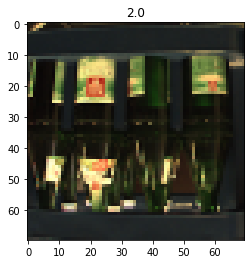

In [71]:
[box, box_class] = random_box(STUD_ARR)
plt.imshow(box/255)
plt.title(box_class)
plt.show()

In [72]:
#def generate_images(empyty_scene):
empyty_scene = ROOM_ARR[0]
group_img = np.array(empyty_scene)

# Generating random initial positions
[x_init, y_init, w_rand, h_rand] = random_pos_gen()

# BOX_1: x_lim => random, y_lim => on the board (small variation)
[box, box_class] = random_box(STUD_ARR)
group_img, annot_1, b1_x, b1_y = place_box(group_img, box, x_init, y_init, w_rand, h_rand)
annot_1 = annot_1 * box_class

# Generating random initial positions
[x_init, y_init, w_rand, h_rand] = random_pos_gen()

# BOX_2: x_lim => random, y_lim => (y_lim + height) of BOX_1
[box, box_class] = random_box(STUD_ARR)
group_img, annot_2, b2_x, b2_y = place_box(group_img, box, x_init, b1_y, w_rand, h_rand)
annot_2 = annot_2 * box_class

# Generating random initial positions
[x_init, y_init, w_rand, h_rand] = random_pos_gen()

# BOX_3: x_lim => (x_lim + width) of BOX_1 , y_lim => on the board (small variation)
[box, box_class] = random_box(STUD_ARR)
group_img, annot_3, b3_x, b3_y = place_box(group_img, box, b1_x, y_init, w_rand, h_rand)
annot_3 = annot_3 * box_class

# BOX_4: x_lim => min( (x_lim + width) of BOX_1 and BOX_2 )
# y_lim => (y_lim + height) of BOX_3
[box, box_class] = random_box(STUD_ARR)
group_img, annot_4, b4_x, b4_y = place_box(group_img, box, min(b1_x,b2_x), b3_y, w_rand, h_rand)
annot_4 = annot_4 * box_class

#plt.imshow(group_img/255)
#plt.grid('on',color='black')

# Annotations
annots = [annot_1, annot_2, annot_3, annot_4]

annotations = sum(annots)
annotations[annotations>255*6] = 0 # Limiting values above (only works when above 6, not ideal)

image = group_img
ann = annotations

#return image, ann


In [73]:
## WHEN USING AS FUNCTION
## NOT WORKING 
## OVERWRITIN
empyty_scene = np.array(ROOM_ARR[0])
image, annotation = generate_images(empyty_scene)

plt.imshow(image/255)
plt.grid('on',color='black')

plt.imshow(annotation/255)
plt.colorbar()
plt.grid('on',color='black')

NameError: name 'generate_images' is not defined

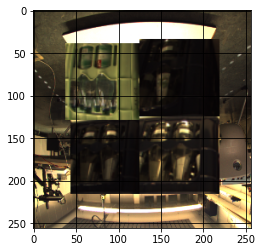

In [74]:
plt.imshow(group_img/255)
plt.grid('on',color='black')

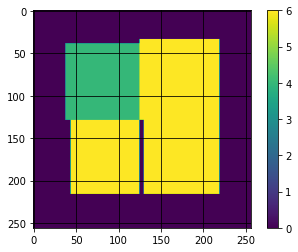

In [75]:
plt.imshow(annotations/255)
plt.colorbar()
plt.grid('on',color='black')